In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 10000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.6517]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.8774]], requires_grad=True)
alpha:  tensor([0.2101])
gt ols coef:  [[0.6534512]]
gt ols intercept:  [-0.8748568]
trunc ols coef:  [[0.08947102]]
trunc ols intercept:  [0.67517924]


Text(0, 0.5, 'y')

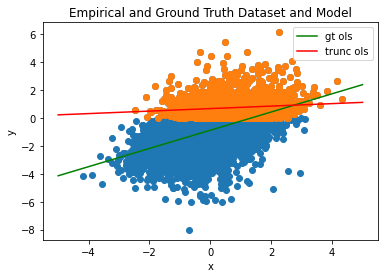

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
# m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + laplace.sample(ch.Size([X.size(0)]))
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [19]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.0143)
beta:  tensor(4.0143)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([0.6316])
trunc reg noise var:  tensor([2.0522])


Text(0, 0.5, 'y')

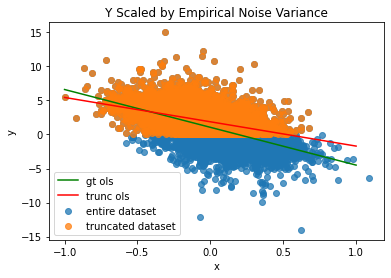

In [52]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)
emp_noise_scale = ch.sqrt(emp_noise_var/2) 

emp_stand_y_trunc = y_trunc / emp_noise_scale
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / emp_noise_scale

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([1.2631])
reg noise var:  tensor([2.0303])


Text(0, 0.5, 'y')

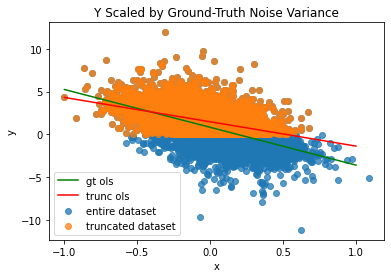

In [53]:
stand_noised, stand_y_trunc = noised / noise_scale, y_trunc / noise_scale

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [54]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_res.weight * emp_noise_scale) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_res.bias * emp_noise_scale)

0 steps | score: [0.08722872287034988]
100 steps | score: [-0.15371833741664886]
200 steps | score: [0.11577165126800537]
300 steps | score: [0.15002448856830597]
400 steps | score: [-0.040850937366485596]
500 steps | score: [0.04271867498755455]
600 steps | score: [0.01830844022333622]
700 steps | score: [0.04730379208922386]
800 steps | score: [-0.052826348692178726]
900 steps | score: [0.10823661088943481]
1000 steps | score: [0.08567563444375992]
1100 steps | score: [-0.0640784278512001]
1200 steps | score: [0.008505544625222683]


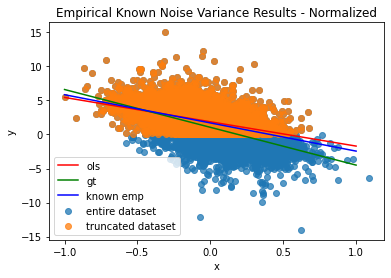

Text(0, 0.5, 'y')

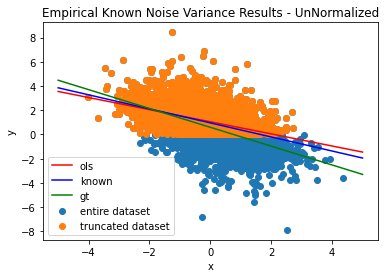

In [55]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [58]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=1, n=100, tol=1e-2, steps=2000)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_res.weight * noise_scale) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_res.bias * noise_scale

0 steps | score: [0.1404706835746765]
100 steps | score: [-0.20729883015155792]
200 steps | score: [-0.019203443080186844]
300 steps | score: [0.15922656655311584]
400 steps | score: [0.26590561866760254]
500 steps | score: [-0.19839715957641602]
600 steps | score: [-0.07279006391763687]
700 steps | score: [0.047994550317525864]
800 steps | score: [0.07560958713293076]
900 steps | score: [0.0676669031381607]
1000 steps | score: [-0.28352153301239014]
1100 steps | score: [0.052644044160842896]
1200 steps | score: [-0.017157278954982758]
1300 steps | score: [-0.22028736770153046]
1400 steps | score: [-0.1377340853214264]
1500 steps | score: [0.0061187297105789185]


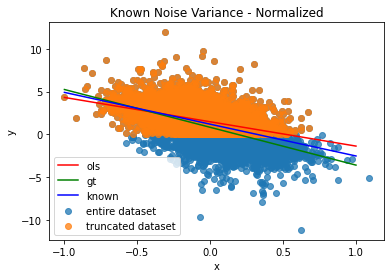

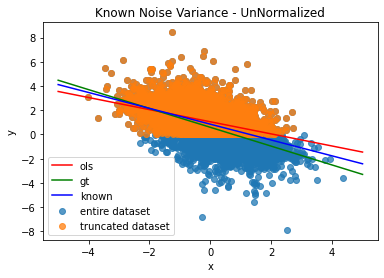

In [59]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [60]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=1, n=100, tol=5e-2, val=100, steps=2000)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * emp_noise_scale) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * emp_noise_scale).detach().numpy()

0 steps | score: [0.2905574440956116, -0.20666351914405823]
100 steps | score: [-0.27120140194892883, -3.2981948852539062]
200 steps | score: [-1.2057424783706665, 2.8927805423736572]
300 steps | score: [-0.8965381383895874, 2.547687530517578]
400 steps | score: [-1.3437919616699219, 3.0747432708740234]
500 steps | score: [-0.338600754737854, 1.6003186702728271]
600 steps | score: [-0.18581794202327728, 1.1041582822799683]
700 steps | score: [-2.0519609451293945, 3.499739170074463]
800 steps | score: [-0.5100373029708862, 1.8548325300216675]
900 steps | score: [-0.8865644335746765, 2.509981870651245]
1000 steps | score: [-0.5900213122367859, 2.0247135162353516]
1100 steps | score: [0.15984177589416504, 0.3845093250274658]
1200 steps | score: [0.22827421128749847, 0.23511837422847748]
1300 steps | score: [-0.3410768210887909, 1.496913194656372]
1400 steps | score: [-0.5526643395423889, 1.8662344217300415]
1500 steps | score: [0.03078850731253624, 0.7469772100448608]
1600 steps | score: 

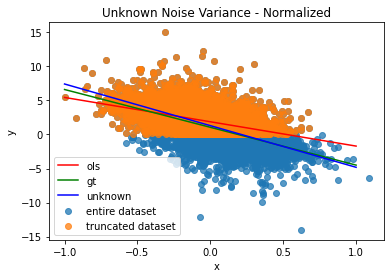

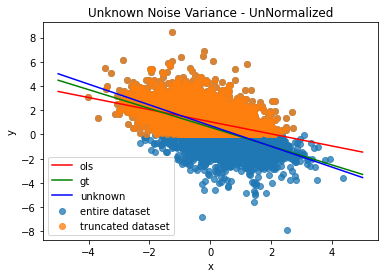

In [61]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [12]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 10)
args.__setattr__('samples', 1000)
args.__setattr__('n', 100)

EXP = 'FixedOracle1kSamples'

In [13]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [14]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1

# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
noise_var = 2*ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)

C = [-2.5, -2, -1.75, -1.5, -1.25, -1.0, -.75, -.5, -.25, 0.0]

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'c': float,
        'num_samples': int,
        'noise_var': float, 
    })
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        noised = gt(X) + laplace.sample(ch.Size([X.size(0)]))
        
    for c in C: 
        phi = oracle.Left(c)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        print("alpha: ", alpha)
        
        val = int(.2*x_trunc.size(0))
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_noise_scale = ch.sqrt(emp_noise_var/2) 
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        known_kwargs = { 
            'phi': oracle.Left(c/ch.sqrt(noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)
        with ch.no_grad():
            w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
            known_params = ch.cat([w, w0]).flatten()
            
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params),
                'known_time': total_time, 
            })
        
        
        # truncated regression with unknown variance
        unknown_kwargs = { 
            'phi': oracle.Left(c/ch.sqrt(emp_noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta), ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)))
            unknown_params = ch.cat([w, w0]).flatten()

            # unknown results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_trunc_reg.variance * emp_noise_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': float(noise_var), 
            'c': c,
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/FixedOracle1kSamples/ce066718-cd70-421b-b0bd-9b5d608c717e
alpha:  tensor([0.8160])
Iteration: 0.0 | Score: [0.029057517647743225]
Iteration: 1.0 | Score: [0.005541754886507988]
Iteration: 0.0 | Score: [0.12669384479522705, -0.037021540105342865]
Iteration: 1.0 | Score: [0.08669540286064148, -0.11755559593439102]
Iteration: 2.0 | Score: [0.05604901909828186, -0.07999210059642792]
Iteration: 3.0 | Score: [0.06474184989929199, -0.10975836962461472]
Iteration: 4.0 | Score: [0.046124957501888275, -0.07521487027406693]
Iteration: 5.0 | Score: [0.06739016622304916, -0.11906994879245758]
Iteration: 6.0 | Score: [0.044662874191999435, -0.06639138609170914]
Iteration: 7.0 | Score: [0.058509428054094315, -0.1012888178229332]
Iteration: 8.0 | Score: [0.04613448306918144, -0.0781172588467598]
Iteration: 9.0 | Score: [0.03821122273802757, -0.07439609616994858]
Iteration: 10.0 | Score: [0.04774671792984009, -0.0914188101887703]
Iteration: 11.0 | Score: [0

Iteration: 16.0 | Score: [0.015950828790664673, 0.054257847368717194]
Iteration: 17.0 | Score: [-0.0041494970209896564, 0.05563361197710037]
Iteration: 18.0 | Score: [0.011447490192949772, 0.04851027950644493]
Iteration: 19.0 | Score: [-0.01289405021816492, 0.08350806683301926]
Iteration: 20.0 | Score: [-0.01730955019593239, 0.08670827001333237]
Iteration: 21.0 | Score: [-0.005538183264434338, 0.06295913457870483]
Iteration: 22.0 | Score: [0.009233054704964161, 0.05716507136821747]
Iteration: 23.0 | Score: [0.01817099004983902, 0.050915125757455826]
Iteration: 24.0 | Score: [-0.0001490564172854647, 0.05820165574550629]
Iteration: 25.0 | Score: [-0.007792046759277582, 0.0710783302783966]
alpha:  tensor([0.6550])
Iteration: 0.0 | Score: [0.14795228838920593]
Iteration: 1.0 | Score: [0.09765978902578354]
Iteration: 2.0 | Score: [0.07684148848056793]
Iteration: 3.0 | Score: [0.055128831416368484]
Iteration: 4.0 | Score: [0.05199886113405228]
Iteration: 5.0 | Score: [0.06092583388090134]
It

Iteration: 18.0 | Score: [-0.018210234120488167, -0.06993613392114639]
Iteration: 19.0 | Score: [-0.005673608742654324, -0.07929761707782745]
Iteration: 20.0 | Score: [-0.010762935504317284, -0.07893145829439163]
Iteration: 21.0 | Score: [0.00082179787568748, -0.10004769265651703]
Iteration: 22.0 | Score: [0.011468075215816498, -0.09544596076011658]
Iteration: 23.0 | Score: [-0.0065636951476335526, -0.08636446297168732]
Iteration: 24.0 | Score: [-0.0074338545091450214, -0.07069560140371323]
Iteration: 25.0 | Score: [-0.01585347019135952, -0.06933917105197906]
alpha:  tensor([0.5720])
Iteration: 0.0 | Score: [0.19510361552238464]
Iteration: 1.0 | Score: [0.040078695863485336]
Iteration: 2.0 | Score: [0.06790419667959213]
Iteration: 3.0 | Score: [0.043472811579704285]
Iteration: 4.0 | Score: [0.06587876379489899]
Iteration: 5.0 | Score: [0.05754055827856064]
Iteration: 6.0 | Score: [0.0857495367527008]
Iteration: 7.0 | Score: [0.05387558043003082]
Iteration: 8.0 | Score: [0.0700068771839

Iteration: 22.0 | Score: [-0.018646588549017906, 0.08409658074378967]
Iteration: 23.0 | Score: [-0.05001377686858177, 0.15838541090488434]
Iteration: 24.0 | Score: [-0.018407180905342102, 0.09736822545528412]
Iteration: 25.0 | Score: [-0.03355306759476662, 0.13250167667865753]
Logging in: /home/gridsan/stefanou/Regression/FixedOracle1kSamples/aa18e79a-fdb2-4b57-abc0-93da1dbb7274
alpha:  tensor([0.8140])
Iteration: 0.0 | Score: [0.007121574133634567]
Iteration: 1.0 | Score: [-0.08701089769601822]
Iteration: 2.0 | Score: [-0.156464621424675]
Iteration: 3.0 | Score: [-0.06998472660779953]
Iteration: 4.0 | Score: [-0.14743369817733765]
Iteration: 5.0 | Score: [-0.11702167242765427]
Iteration: 6.0 | Score: [-0.09957721829414368]
Iteration: 7.0 | Score: [-0.09914059937000275]
Iteration: 8.0 | Score: [-0.11104985326528549]
Iteration: 9.0 | Score: [-0.07661418616771698]
Iteration: 10.0 | Score: [-0.1135343462228775]
Iteration: 11.0 | Score: [-0.08774235099554062]
Iteration: 12.0 | Score: [-0.1

Iteration: 15.0 | Score: [-0.003230483504012227, -0.016134941950440407]
Iteration: 16.0 | Score: [-0.051674630492925644, 0.032182447612285614]
Iteration: 17.0 | Score: [-0.03510839119553566, 0.020578503608703613]
Iteration: 18.0 | Score: [-0.03556651622056961, 0.014544080011546612]
Iteration: 19.0 | Score: [-0.016420038416981697, -0.005390565376728773]
Iteration: 20.0 | Score: [-0.05518459528684616, 0.02437790296971798]
Iteration: 21.0 | Score: [-0.02871859073638916, 0.02601710706949234]
Iteration: 22.0 | Score: [-0.040271446108818054, 0.02498340792953968]
Iteration: 23.0 | Score: [-0.027910489588975906, 0.013323117047548294]
Iteration: 24.0 | Score: [-0.03762457147240639, 0.009718812070786953]
Iteration: 25.0 | Score: [-0.04364198446273804, 0.01701219752430916]
alpha:  tensor([0.6750])
Iteration: 0.0 | Score: [0.18820908665657043]
Iteration: 1.0 | Score: [0.08383341133594513]
Iteration: 2.0 | Score: [0.039322227239608765]
Iteration: 3.0 | Score: [0.029017336666584015]
Iteration: 4.0 |

Iteration: 11.0 | Score: [0.024111028760671616, 0.09606697410345078]
Iteration: 12.0 | Score: [-0.02510221302509308, 0.18322843313217163]
Iteration: 13.0 | Score: [0.014659610576927662, 0.10996560752391815]
Iteration: 14.0 | Score: [0.005758597049862146, 0.1319129467010498]
Iteration: 15.0 | Score: [-0.006112530827522278, 0.14699357748031616]
Iteration: 16.0 | Score: [-0.03942213952541351, 0.20487776398658752]
Iteration: 17.0 | Score: [-0.033741295337677, 0.19778089225292206]
Iteration: 18.0 | Score: [-0.026100456714630127, 0.17894574999809265]
Iteration: 19.0 | Score: [-0.02915945276618004, 0.19242846965789795]
Iteration: 20.0 | Score: [-0.05266866832971573, 0.22969134151935577]
Iteration: 21.0 | Score: [-0.029533158987760544, 0.18517228960990906]
Iteration: 22.0 | Score: [-0.026572832837700844, 0.18414340913295746]
Iteration: 23.0 | Score: [-0.03240303322672844, 0.18387793004512787]
Iteration: 24.0 | Score: [-0.022696806117892265, 0.18320800364017487]
Iteration: 25.0 | Score: [-0.020

Iteration: 10.0 | Score: [0.048542290925979614, -0.08952285349369049]
Iteration: 11.0 | Score: [0.05793539807200432, -0.09738814830780029]
Iteration: 12.0 | Score: [0.06739284098148346, -0.10174521803855896]
Iteration: 13.0 | Score: [0.07918635755777359, -0.11986427009105682]
Iteration: 14.0 | Score: [0.07449803501367569, -0.11820331960916519]
Iteration: 15.0 | Score: [0.08249398320913315, -0.12343692779541016]
Iteration: 16.0 | Score: [0.06899850070476532, -0.10170082747936249]
Iteration: 17.0 | Score: [0.08895087242126465, -0.12484299391508102]
Iteration: 18.0 | Score: [0.06898032128810883, -0.10323449224233627]
Iteration: 19.0 | Score: [0.0701824277639389, -0.11776039004325867]
Iteration: 20.0 | Score: [0.07419265061616898, -0.11482758820056915]
Iteration: 21.0 | Score: [0.08017315715551376, -0.13199874758720398]
Iteration: 22.0 | Score: [0.07317551970481873, -0.10804296284914017]
Iteration: 23.0 | Score: [0.08484799414873123, -0.12862683832645416]
Iteration: 24.0 | Score: [0.066399

Iteration: 13.0 | Score: [0.03615085780620575, -0.047122351825237274]
Iteration: 14.0 | Score: [0.08398918062448502, -0.13878916203975677]
Iteration: 15.0 | Score: [0.0875529944896698, -0.1488836705684662]
Iteration: 16.0 | Score: [0.060998570173978806, -0.09123294055461884]
Iteration: 17.0 | Score: [0.04498673975467682, -0.06903243809938431]
Iteration: 18.0 | Score: [0.08062023669481277, -0.13528186082839966]
Iteration: 19.0 | Score: [0.09972163289785385, -0.15439081192016602]
Iteration: 20.0 | Score: [0.0675305724143982, -0.10223045945167542]
Iteration: 21.0 | Score: [0.0423574261367321, -0.07501760125160217]
Iteration: 22.0 | Score: [0.07586411386728287, -0.11609821766614914]
Iteration: 23.0 | Score: [0.07195568084716797, -0.11652342230081558]
Iteration: 24.0 | Score: [0.05104203522205353, -0.08244221657514572]
Iteration: 25.0 | Score: [0.05986182391643524, -0.08327953517436981]
alpha:  tensor([0.6800])
Iteration: 0.0 | Score: [0.1586921364068985]
Iteration: 1.0 | Score: [0.07237700

Iteration: 12.0 | Score: [0.05714873969554901]
Iteration: 13.0 | Score: [0.04970366507768631]
Iteration: 14.0 | Score: [0.034146856516599655]
Iteration: 15.0 | Score: [0.0581994354724884]
Iteration: 16.0 | Score: [0.04684184864163399]
Iteration: 17.0 | Score: [0.03155924379825592]
Iteration: 18.0 | Score: [0.04015683755278587]
Iteration: 19.0 | Score: [0.04945697635412216]
Iteration: 20.0 | Score: [0.03440847992897034]
Iteration: 21.0 | Score: [0.045169804245233536]
Iteration: 22.0 | Score: [0.03642512112855911]
Iteration: 23.0 | Score: [0.04658499360084534]
Iteration: 24.0 | Score: [0.03998024761676788]
Iteration: 25.0 | Score: [0.03939243406057358]
Iteration: 0.0 | Score: [0.07769407331943512, -0.11600904166698456]
Iteration: 1.0 | Score: [-0.17130707204341888, 0.17154628038406372]
Iteration: 2.0 | Score: [-0.17388108372688293, 0.1413419544696808]
Iteration: 3.0 | Score: [-0.1915234923362732, 0.15154653787612915]
Iteration: 4.0 | Score: [-0.1571984589099884, 0.08124853670597076]
Iter

Iteration: 21.0 | Score: [-0.06235629320144653]
Iteration: 22.0 | Score: [-0.06358999013900757]
Iteration: 23.0 | Score: [-0.07184819132089615]
Iteration: 24.0 | Score: [-0.06420403718948364]
Iteration: 25.0 | Score: [-0.07963133603334427]
Iteration: 0.0 | Score: [0.1260962039232254, 0.0024273842573165894]
Iteration: 1.0 | Score: [0.00347872544080019, 0.16177187860012054]
Iteration: 2.0 | Score: [0.04778977856040001, 0.02649550512433052]
Iteration: 3.0 | Score: [0.16946808993816376, -0.2621179223060608]
Iteration: 4.0 | Score: [-0.030262907966971397, 0.16226044297218323]
Iteration: 5.0 | Score: [0.020504619926214218, 0.05305706709623337]
Iteration: 6.0 | Score: [0.05678321048617363, -0.010213535279035568]
Iteration: 7.0 | Score: [-0.012939748354256153, 0.11932236701250076]
Iteration: 8.0 | Score: [-0.020684847608208656, 0.12181930243968964]
Iteration: 9.0 | Score: [0.09932532161474228, -0.11702921241521835]
Iteration: 10.0 | Score: [0.26648664474487305, -0.5261387825012207]
Iteration: 

Iteration: 18.0 | Score: [0.1308218240737915]
Iteration: 19.0 | Score: [0.13743719458580017]
Iteration: 20.0 | Score: [0.129673033952713]
Iteration: 21.0 | Score: [0.12704646587371826]
Iteration: 22.0 | Score: [0.12754933536052704]
Iteration: 23.0 | Score: [0.12957404553890228]
Iteration: 24.0 | Score: [0.131818026304245]
Iteration: 25.0 | Score: [0.11571348458528519]
Iteration: 0.0 | Score: [0.17599090933799744, -0.07837630063295364]
Iteration: 1.0 | Score: [0.03408070653676987, -0.0007752282544970512]
Iteration: 2.0 | Score: [0.17299102246761322, -0.22515501081943512]
Iteration: 3.0 | Score: [0.10174363106489182, -0.11057880520820618]
Iteration: 4.0 | Score: [0.13554026186466217, -0.18786412477493286]
Iteration: 5.0 | Score: [0.09195096045732498, -0.08785570412874222]
Iteration: 6.0 | Score: [0.05151200667023659, -0.03833788260817528]
Iteration: 7.0 | Score: [0.1322273164987564, -0.1613333821296692]
Iteration: 8.0 | Score: [0.13565513491630554, -0.16042841970920563]
Iteration: 9.0 | 

Iteration: 3.0 | Score: [0.05886384844779968]
Iteration: 4.0 | Score: [0.02184000425040722]
Iteration: 5.0 | Score: [-0.07459044456481934]
Iteration: 6.0 | Score: [-0.03149665892124176]
Iteration: 7.0 | Score: [-0.044304024428129196]
Iteration: 8.0 | Score: [0.042341578751802444]
Iteration: 9.0 | Score: [0.024862833321094513]
Iteration: 10.0 | Score: [-0.03647642582654953]
Iteration: 11.0 | Score: [-0.03892664983868599]
Iteration: 12.0 | Score: [-0.016247227787971497]
Iteration: 13.0 | Score: [0.018300311639904976]
Iteration: 14.0 | Score: [0.009390942752361298]
Iteration: 0.0 | Score: [0.07172631472349167, 0.0829237774014473]
Iteration: 1.0 | Score: [0.003607824444770813, 0.09096253663301468]
Iteration: 2.0 | Score: [-0.06307405233383179, 0.18434178829193115]
Iteration: 3.0 | Score: [-0.057083483785390854, 0.15125901997089386]
Iteration: 4.0 | Score: [-0.023322759196162224, 0.06263972073793411]
Iteration: 5.0 | Score: [0.02037379890680313, 0.007282651960849762]
Iteration: 6.0 | Score:

Iteration: 16.0 | Score: [-0.015148695558309555, -0.09914987534284592]
Iteration: 17.0 | Score: [-0.04849756881594658, -0.03897755965590477]
Iteration: 18.0 | Score: [-0.06222369149327278, -0.006493663415312767]
Iteration: 19.0 | Score: [-0.0672396570444107, 0.008955122902989388]
Iteration: 20.0 | Score: [-0.07020781934261322, -0.0010185698047280312]
Iteration: 21.0 | Score: [-0.043733932077884674, -0.035731635987758636]
Iteration: 22.0 | Score: [-0.09039213508367538, 0.03909287601709366]
Iteration: 23.0 | Score: [-0.05923588201403618, -0.009141460061073303]
Iteration: 24.0 | Score: [-0.04573711007833481, -0.043224651366472244]
Iteration: 25.0 | Score: [-0.0508357435464859, -0.041032180190086365]
alpha:  tensor([0.5820])
Iteration: 0.0 | Score: [0.08049903810024261]
Iteration: 1.0 | Score: [-0.08746902644634247]
Iteration: 2.0 | Score: [-0.10878057032823563]
Iteration: 3.0 | Score: [-0.059640221297740936]
Iteration: 4.0 | Score: [-0.02369147166609764]
Iteration: 5.0 | Score: [-0.027936

Iteration: 16.0 | Score: [-0.030050599947571754, 0.06748640537261963]
Iteration: 17.0 | Score: [-0.02418304793536663, 0.0591953881084919]
Iteration: 18.0 | Score: [-0.028334107249975204, 0.07567291706800461]
Iteration: 19.0 | Score: [-0.03305470198392868, 0.06268294900655746]
Iteration: 20.0 | Score: [-0.033113762736320496, 0.08075150847434998]
Iteration: 21.0 | Score: [-0.009420120157301426, 0.04581047594547272]
Iteration: 22.0 | Score: [-0.0265352725982666, 0.06393343210220337]
Iteration: 23.0 | Score: [-0.011612356640398502, 0.06503243744373322]
Iteration: 24.0 | Score: [-0.034215983003377914, 0.07197607308626175]
Iteration: 25.0 | Score: [-0.023124027997255325, 0.056585922837257385]
alpha:  tensor([0.7730])
Iteration: 0.0 | Score: [0.1269001066684723]
Iteration: 1.0 | Score: [0.027745645493268967]
Iteration: 2.0 | Score: [-0.05158453807234764]
Iteration: 3.0 | Score: [0.050333522260189056]
Iteration: 4.0 | Score: [-0.055105745792388916]
Iteration: 5.0 | Score: [0.05842284485697746]

Iteration: 6.0 | Score: [-0.07129788398742676]
Iteration: 7.0 | Score: [-0.056830234825611115]
Iteration: 8.0 | Score: [-0.0670292004942894]
Iteration: 9.0 | Score: [-0.06181959807872772]
Iteration: 10.0 | Score: [-0.0712030753493309]
Iteration: 11.0 | Score: [-0.05685237795114517]
Iteration: 12.0 | Score: [-0.062483470886945724]
Iteration: 13.0 | Score: [-0.06433224678039551]
Iteration: 14.0 | Score: [-0.05567023158073425]
Iteration: 15.0 | Score: [-0.0682622566819191]
Iteration: 16.0 | Score: [-0.05243629962205887]
Iteration: 17.0 | Score: [-0.049876995384693146]
Iteration: 18.0 | Score: [-0.04644922539591789]
Iteration: 19.0 | Score: [-0.04980657249689102]
Iteration: 20.0 | Score: [-0.07507170736789703]
Iteration: 21.0 | Score: [-0.07118301093578339]
Iteration: 22.0 | Score: [-0.052351634949445724]
Iteration: 23.0 | Score: [-0.06173451244831085]
Iteration: 24.0 | Score: [-0.05312573164701462]
Iteration: 25.0 | Score: [-0.0597878098487854]
Iteration: 0.0 | Score: [-0.1077562719583511

Iteration: 8.0 | Score: [-0.05881362035870552, 0.15742547810077667]
Iteration: 9.0 | Score: [-0.1235690489411354, 0.2817069888114929]
Iteration: 10.0 | Score: [-0.10041618347167969, 0.23975186049938202]
Iteration: 11.0 | Score: [-0.09850083291530609, 0.23587875068187714]
Iteration: 12.0 | Score: [-0.0922384262084961, 0.22332991659641266]
Iteration: 13.0 | Score: [-0.09880373626947403, 0.23354634642601013]
Iteration: 14.0 | Score: [-0.11520571261644363, 0.256454199552536]
Iteration: 15.0 | Score: [-0.12139783054590225, 0.2749093174934387]
Iteration: 16.0 | Score: [-0.09896218776702881, 0.23945043981075287]
Iteration: 17.0 | Score: [-0.09040410816669464, 0.226518452167511]
Iteration: 18.0 | Score: [-0.10191380232572556, 0.23648229241371155]
Iteration: 19.0 | Score: [-0.09882373362779617, 0.2357224076986313]
Iteration: 20.0 | Score: [-0.09741591662168503, 0.24205298721790314]
Iteration: 21.0 | Score: [-0.10018186271190643, 0.23706363141536713]
Iteration: 22.0 | Score: [-0.1004563719034195

Iteration: 6.0 | Score: [-0.1333969682455063]
Iteration: 7.0 | Score: [-0.11690624803304672]
Iteration: 8.0 | Score: [-0.12419088184833527]
Iteration: 9.0 | Score: [-0.1217714250087738]
Iteration: 10.0 | Score: [-0.09977460652589798]
Iteration: 11.0 | Score: [-0.10504534840583801]
Iteration: 12.0 | Score: [-0.0916353091597557]
Iteration: 13.0 | Score: [-0.08628722280263901]
Iteration: 14.0 | Score: [-0.1034686267375946]
Iteration: 15.0 | Score: [-0.10447147488594055]
Iteration: 16.0 | Score: [-0.0927460566163063]
Iteration: 17.0 | Score: [-0.09845554828643799]
Iteration: 18.0 | Score: [-0.11494986712932587]
Iteration: 19.0 | Score: [-0.09540212154388428]
Iteration: 20.0 | Score: [-0.11200958490371704]
Iteration: 21.0 | Score: [-0.09148193150758743]
Iteration: 22.0 | Score: [-0.10885041952133179]
Iteration: 23.0 | Score: [-0.10541127622127533]
Iteration: 24.0 | Score: [-0.1217111125588417]
Iteration: 25.0 | Score: [-0.10686546564102173]
Iteration: 0.0 | Score: [0.047112349420785904, 0.0

Iteration: 5.0 | Score: [0.13962624967098236, -0.19963327050209045]
Iteration: 6.0 | Score: [0.19819357991218567, -0.30001989006996155]
Iteration: 7.0 | Score: [0.08201921731233597, -0.09620636701583862]
Iteration: 8.0 | Score: [0.07498591393232346, -0.10204901546239853]
Iteration: 9.0 | Score: [0.09949599206447601, -0.1149851605296135]
Iteration: 10.0 | Score: [0.10823339968919754, -0.14359624683856964]
Iteration: 11.0 | Score: [0.13782213628292084, -0.18360424041748047]
Iteration: 12.0 | Score: [0.1247304156422615, -0.16794453561306]
Iteration: 13.0 | Score: [0.1449451595544815, -0.21412980556488037]
Iteration: 14.0 | Score: [0.13315929472446442, -0.18850292265415192]
Iteration: 15.0 | Score: [0.12279349565505981, -0.1627291887998581]
Iteration: 16.0 | Score: [0.10593090951442719, -0.14787109196186066]
Iteration: 17.0 | Score: [0.12247012555599213, -0.1690855175256729]
Iteration: 18.0 | Score: [0.13015151023864746, -0.1907455325126648]
Iteration: 19.0 | Score: [0.11050911992788315, -

Iteration: 5.0 | Score: [0.007382092531770468, 0.04248357564210892]
Iteration: 6.0 | Score: [0.06750033795833588, -0.07334145903587341]
Iteration: 7.0 | Score: [0.04552517086267471, -0.03128853440284729]
Iteration: 8.0 | Score: [0.08328050374984741, -0.1079021692276001]
Iteration: 9.0 | Score: [0.023823995143175125, -0.0012272689491510391]
Iteration: 10.0 | Score: [0.043575964868068695, -0.027049969881772995]
Iteration: 11.0 | Score: [0.021596496924757957, 0.016428088769316673]
Iteration: 12.0 | Score: [0.01335943304002285, 0.016991738229990005]
Iteration: 13.0 | Score: [0.03818288818001747, -0.012139596045017242]
Iteration: 14.0 | Score: [0.05096365138888359, -0.04874001443386078]
Iteration: 15.0 | Score: [0.04159409552812576, -0.025096695870161057]
Iteration: 16.0 | Score: [0.05706987529993057, -0.048707470297813416]
Iteration: 17.0 | Score: [0.03286946192383766, -0.00991526897996664]
Iteration: 18.0 | Score: [0.05544078350067139, -0.0627768337726593]
Iteration: 19.0 | Score: [0.0302

Iteration: 4.0 | Score: [-0.03252076357603073, -0.004620026797056198]
Iteration: 5.0 | Score: [0.03590098023414612, -0.10768508911132812]
Iteration: 6.0 | Score: [-0.03538328409194946, -0.0094711072742939]
Iteration: 7.0 | Score: [0.03607400506734848, -0.11983302235603333]
Iteration: 8.0 | Score: [-0.02203241176903248, -0.01561545580625534]
Iteration: 9.0 | Score: [0.031735967844724655, -0.08401401340961456]
Iteration: 10.0 | Score: [0.0023968403693288565, -0.04236409813165665]
Iteration: 11.0 | Score: [0.029747866094112396, -0.10336624085903168]
Iteration: 12.0 | Score: [0.003013630397617817, -0.06729477643966675]
Iteration: 13.0 | Score: [0.01945296674966812, -0.08135318756103516]
Iteration: 14.0 | Score: [0.0197985228151083, -0.06691381335258484]
Iteration: 15.0 | Score: [0.02181333303451538, -0.07466981559991837]
Iteration: 16.0 | Score: [0.014930697157979012, -0.07434289902448654]
Iteration: 17.0 | Score: [0.013469545170664787, -0.08186577260494232]
Iteration: 18.0 | Score: [-0.00

Iteration: 23.0 | Score: [-0.1362244188785553, 0.24770230054855347]
Iteration: 24.0 | Score: [-0.12897764146327972, 0.2306315004825592]
Iteration: 25.0 | Score: [-0.12654335796833038, 0.2257937788963318]
alpha:  tensor([0.6530])
Iteration: 0.0 | Score: [0.2172158807516098]
Iteration: 1.0 | Score: [0.12201850116252899]
Iteration: 2.0 | Score: [0.11218290030956268]
Iteration: 3.0 | Score: [-0.007479008287191391]
Iteration: 0.0 | Score: [0.24587878584861755, -0.18317611515522003]
Iteration: 1.0 | Score: [0.10314901173114777, -0.08103767037391663]
Iteration: 2.0 | Score: [0.21568752825260162, -0.31405356526374817]
Iteration: 3.0 | Score: [0.20159874856472015, -0.3243476152420044]
Iteration: 4.0 | Score: [0.2040145993232727, -0.3333915174007416]
Iteration: 5.0 | Score: [0.14189909398555756, -0.21712937951087952]
Iteration: 6.0 | Score: [0.13044816255569458, -0.21094420552253723]
Iteration: 7.0 | Score: [0.15256188809871674, -0.2206808626651764]
Iteration: 8.0 | Score: [0.16596989333629608, 

Iteration: 7.0 | Score: [0.1038995012640953, -0.18449954688549042]
Iteration: 8.0 | Score: [0.0918075442314148, -0.1818195879459381]
Iteration: 9.0 | Score: [-0.010965847410261631, 0.022998496890068054]
Iteration: 10.0 | Score: [-0.06622849404811859, 0.12003893405199051]
Iteration: 11.0 | Score: [0.12090299278497696, -0.23325738310813904]
Iteration: 12.0 | Score: [0.10296117514371872, -0.20597653090953827]
Iteration: 13.0 | Score: [0.03848695755004883, -0.06769827753305435]
Iteration: 14.0 | Score: [-0.0065703908912837505, 0.0055491309612989426]
alpha:  tensor([0.5340])
Iteration: 0.0 | Score: [0.31814417243003845]
Iteration: 1.0 | Score: [0.14741799235343933]
Iteration: 2.0 | Score: [0.1810702383518219]
Iteration: 3.0 | Score: [0.12551645934581757]
Iteration: 4.0 | Score: [0.15914826095104218]
Iteration: 5.0 | Score: [0.15519791841506958]
Iteration: 6.0 | Score: [0.15852370858192444]
Iteration: 7.0 | Score: [0.1722140610218048]
Iteration: 8.0 | Score: [0.14969345927238464]
Iteration: 

Iteration: 24.0 | Score: [-0.2411477416753769]
Iteration: 25.0 | Score: [-0.2307257056236267]
Iteration: 0.0 | Score: [0.026923181489109993, 0.20107881724834442]
Iteration: 1.0 | Score: [-0.01802677847445011, 0.14126352965831757]
Iteration: 2.0 | Score: [-0.05608515441417694, 0.17217932641506195]
Iteration: 3.0 | Score: [-0.01781913824379444, 0.0907994955778122]
Iteration: 4.0 | Score: [-0.029141873121261597, 0.12377292662858963]
Iteration: 5.0 | Score: [-0.05195008963346481, 0.16206282377243042]
Iteration: 6.0 | Score: [-0.00826441589742899, 0.086395263671875]
Iteration: 7.0 | Score: [-0.03618938848376274, 0.12334957718849182]
Iteration: 8.0 | Score: [-0.049346860498189926, 0.15177717804908752]
Iteration: 9.0 | Score: [-0.015236172825098038, 0.09258277714252472]
Iteration: 10.0 | Score: [-0.03560863435268402, 0.1311754435300827]
Iteration: 11.0 | Score: [-0.046151697635650635, 0.15610627830028534]
Iteration: 12.0 | Score: [-0.022956574335694313, 0.10479798913002014]
Iteration: 13.0 | 

Iteration: 2.0 | Score: [-0.11165671795606613, 0.1286306381225586]
Iteration: 3.0 | Score: [-0.1103127971291542, 0.09442055225372314]
Iteration: 4.0 | Score: [-0.08539803326129913, 0.0646151602268219]
Iteration: 5.0 | Score: [-0.06053280457854271, 0.0051306188106536865]
Iteration: 6.0 | Score: [-0.026301121339201927, -0.04922601953148842]
Iteration: 7.0 | Score: [-0.006311868317425251, -0.10448932647705078]
Iteration: 8.0 | Score: [-0.03881552815437317, -0.03865543007850647]
Iteration: 9.0 | Score: [-0.022077202796936035, -0.05019721761345863]
Iteration: 10.0 | Score: [-0.0058667343109846115, -0.10411275178194046]
Iteration: 11.0 | Score: [-0.05021720007061958, -0.017432186752557755]
Iteration: 12.0 | Score: [-0.053180694580078125, -0.0048309508711099625]
Iteration: 13.0 | Score: [-0.0836142972111702, 0.04908100143074989]
Iteration: 14.0 | Score: [-0.07829684019088745, 0.017696693539619446]
Iteration: 15.0 | Score: [-0.07204464077949524, 0.021680675446987152]
Iteration: 16.0 | Score: [

Iteration: 22.0 | Score: [-0.13650520145893097, 0.2265915721654892]
Iteration: 23.0 | Score: [-0.13708791136741638, 0.22146829962730408]
Iteration: 24.0 | Score: [-0.13293610513210297, 0.20971077680587769]
Iteration: 25.0 | Score: [-0.11938619613647461, 0.19262811541557312]
alpha:  tensor([0.5220])
Iteration: 0.0 | Score: [0.1601625382900238]
Iteration: 1.0 | Score: [-0.03651362657546997]
Iteration: 2.0 | Score: [0.003489319235086441]
Iteration: 0.0 | Score: [0.1980397254228592, -0.1362895518541336]
Iteration: 1.0 | Score: [0.15231552720069885, -0.13049136102199554]
Iteration: 2.0 | Score: [0.07435513287782669, -0.02171443961560726]
Iteration: 3.0 | Score: [0.02785923331975937, 0.048798128962516785]
Iteration: 4.0 | Score: [0.00748922536149621, 0.07261605560779572]
Iteration: 5.0 | Score: [0.02035333216190338, 0.04225650429725647]
Iteration: 6.0 | Score: [0.10169094800949097, -0.11682700365781784]
Iteration: 7.0 | Score: [0.1478542983531952, -0.20696493983268738]
Iteration: 8.0 | Score

Iteration: 9.0 | Score: [0.07751529663801193, -0.07174378633499146]
Iteration: 10.0 | Score: [0.0210891030728817, 0.01584635116159916]
Iteration: 11.0 | Score: [0.07458458840847015, -0.06422709673643112]
Iteration: 12.0 | Score: [0.021850591525435448, 0.0039904359728097916]
Iteration: 13.0 | Score: [0.05727009475231171, -0.04424343258142471]
Iteration: 14.0 | Score: [0.020250221714377403, 0.004672316834330559]
Iteration: 15.0 | Score: [0.035628337413072586, -0.02414434775710106]
Iteration: 16.0 | Score: [0.02066189795732498, -0.008368737995624542]
Iteration: 17.0 | Score: [0.04746658354997635, -0.015037739649415016]
Iteration: 18.0 | Score: [0.03527943417429924, -0.005990958772599697]
Iteration: 19.0 | Score: [0.027427883818745613, -0.006409290246665478]
Iteration: 20.0 | Score: [0.039857540279626846, -0.011154643259942532]
Iteration: 21.0 | Score: [0.030740417540073395, -0.002240847796201706]
Iteration: 22.0 | Score: [0.037575606256723404, -0.02047840505838394]
Iteration: 23.0 | Score

Iteration: 21.0 | Score: [-0.20209848880767822]
Iteration: 22.0 | Score: [-0.20773687958717346]
Iteration: 23.0 | Score: [-0.1948348879814148]
Iteration: 24.0 | Score: [-0.19408312439918518]
Iteration: 25.0 | Score: [-0.21736875176429749]
Iteration: 0.0 | Score: [0.04541587457060814, 0.15974582731723785]
Iteration: 1.0 | Score: [0.011960973963141441, 0.08199130743741989]
Iteration: 2.0 | Score: [-0.006177321542054415, 0.09334762394428253]
Iteration: 3.0 | Score: [-0.04055212065577507, 0.12934650480747223]
Iteration: 4.0 | Score: [-0.04505975916981697, 0.13661183416843414]
Iteration: 5.0 | Score: [-0.03432871773838997, 0.13594070076942444]
Iteration: 6.0 | Score: [-0.036490548402071, 0.12157164514064789]
Iteration: 7.0 | Score: [-0.00705490680411458, 0.08572573959827423]
Iteration: 8.0 | Score: [0.010447077453136444, 0.03762558847665787]
Iteration: 9.0 | Score: [-0.012726656161248684, 0.09433005750179291]
Iteration: 10.0 | Score: [-0.04703947901725769, 0.13616210222244263]
Iteration: 11

Iteration: 5.0 | Score: [0.09487664699554443]
Iteration: 6.0 | Score: [0.07201977074146271]
Iteration: 7.0 | Score: [0.11569330841302872]
Iteration: 8.0 | Score: [0.14112243056297302]
Iteration: 9.0 | Score: [0.1101016029715538]
Iteration: 10.0 | Score: [0.11386920511722565]
Iteration: 11.0 | Score: [0.09724844992160797]
Iteration: 12.0 | Score: [0.10816234350204468]
Iteration: 13.0 | Score: [0.09881622344255447]
Iteration: 14.0 | Score: [0.09740245342254639]
Iteration: 15.0 | Score: [0.11617919057607651]
Iteration: 16.0 | Score: [0.09270617365837097]
Iteration: 17.0 | Score: [0.11093372106552124]
Iteration: 18.0 | Score: [0.1188061386346817]
Iteration: 19.0 | Score: [0.10648530721664429]
Iteration: 20.0 | Score: [0.12463083863258362]
Iteration: 21.0 | Score: [0.12517978250980377]
Iteration: 22.0 | Score: [0.10150724649429321]
Iteration: 23.0 | Score: [0.08144351840019226]
Iteration: 24.0 | Score: [0.11259053647518158]
Iteration: 25.0 | Score: [0.11448876559734344]
Iteration: 0.0 | Sco

Iteration: 19.0 | Score: [0.03077603504061699, -0.017060887068510056]
Iteration: 20.0 | Score: [0.10371240228414536, -0.15558943152427673]
Iteration: 21.0 | Score: [0.07303209602832794, -0.08232814073562622]
Iteration: 22.0 | Score: [0.08752574026584625, -0.1414629966020584]
Iteration: 23.0 | Score: [0.03573815897107124, -0.03319718688726425]
Iteration: 24.0 | Score: [0.09280768781900406, -0.14518378674983978]
Iteration: 25.0 | Score: [0.05386154353618622, -0.05416591465473175]
Logging in: /home/gridsan/stefanou/Regression/FixedOracle1kSamples/e8b8aee3-d786-4a05-baaa-11f6287060b1
alpha:  tensor([0.8150])
Iteration: 0.0 | Score: [0.10409415513277054]
Iteration: 1.0 | Score: [-0.03632131218910217]
Iteration: 2.0 | Score: [-0.05212237313389778]
Iteration: 3.0 | Score: [-0.02027806267142296]
Iteration: 4.0 | Score: [-0.03863505646586418]
Iteration: 5.0 | Score: [0.0024179695174098015]
Iteration: 0.0 | Score: [0.1355520784854889, 0.033836882561445236]
Iteration: 1.0 | Score: [0.042261023074

Iteration: 3.0 | Score: [-0.060015782713890076, -0.023143798112869263]
Iteration: 4.0 | Score: [-0.059935394674539566, -0.02051369845867157]
Iteration: 5.0 | Score: [-0.031130023300647736, -0.0634794607758522]
Iteration: 6.0 | Score: [-0.1228938177227974, 0.07660391181707382]
Iteration: 7.0 | Score: [-0.07898698002099991, 0.018776118755340576]
Iteration: 8.0 | Score: [-0.04885490983724594, -0.024607554078102112]
Iteration: 9.0 | Score: [-0.04281861335039139, -0.05443184822797775]
Iteration: 10.0 | Score: [-0.0853305533528328, 0.022693773731589317]
Iteration: 11.0 | Score: [-0.09771666675806046, 0.03156640753149986]
Iteration: 12.0 | Score: [-0.07055876404047012, -0.003372061997652054]
Iteration: 13.0 | Score: [-0.06033824011683464, -0.01969512179493904]
Iteration: 14.0 | Score: [-0.06449265033006668, -0.015254255384206772]
Iteration: 15.0 | Score: [-0.10150018334388733, 0.03592037037014961]
Iteration: 16.0 | Score: [-0.08017385005950928, 0.013774752616882324]
Iteration: 17.0 | Score: [

Iteration: 4.0 | Score: [-0.0957087054848671, 0.281036913394928]
Iteration: 5.0 | Score: [-0.13028746843338013, 0.3277357816696167]
Iteration: 6.0 | Score: [-0.15207254886627197, 0.37461790442466736]
Iteration: 7.0 | Score: [-0.16747482120990753, 0.39665737748146057]
Iteration: 8.0 | Score: [-0.11275357007980347, 0.3049323558807373]
Iteration: 9.0 | Score: [-0.06542795896530151, 0.21386925876140594]
Iteration: 10.0 | Score: [-0.07791732996702194, 0.24164870381355286]
Iteration: 11.0 | Score: [-0.09257772564888, 0.2677537202835083]
Iteration: 12.0 | Score: [-0.0727471336722374, 0.23847827315330505]
Iteration: 13.0 | Score: [-0.08142898976802826, 0.2458888739347458]
Iteration: 14.0 | Score: [-0.07705538719892502, 0.22907283902168274]
Iteration: 15.0 | Score: [-0.039237234741449356, 0.1789160966873169]
Iteration: 16.0 | Score: [-0.08861730247735977, 0.24980556964874268]
Iteration: 17.0 | Score: [-0.08979158103466034, 0.2559298872947693]
Iteration: 18.0 | Score: [-0.09605025500059128, 0.25

Iteration: 24.0 | Score: [-0.03076847828924656, 0.01142797525972128]
Iteration: 25.0 | Score: [-0.046268530189991, 0.0569118931889534]


In [10]:
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 10/10 [00:00<00:00, 210.84it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,c,num_samples,noise_var,exp_id
0,0.686213,0.033649,0.363897,0.710870,0.001109,0,0.711380,0.000500,0.073972,0,0.8453,-2.50,8453,2.0,4cd999b7-f325-4a9e-ba10-fccba3865e80
1,0.671272,0.054481,0.373440,0.709827,0.002978,1,0.711007,0.000399,0.009581,2,0.7960,-2.00,7960,2.0,4cd999b7-f325-4a9e-ba10-fccba3865e80
2,0.661681,0.068980,0.386611,0.711743,0.000599,0,0.711140,0.000767,0.052979,2,0.7672,-1.75,7672,2.0,4cd999b7-f325-4a9e-ba10-fccba3865e80
3,0.649478,0.087633,0.402419,0.711398,0.001113,0,0.710990,0.001818,0.038265,2,0.7391,-1.50,7391,2.0,4cd999b7-f325-4a9e-ba10-fccba3865e80
4,0.634422,0.110585,0.408872,0.699189,0.010553,0,0.711676,0.000296,0.021999,3,0.7094,-1.25,7094,2.0,4cd999b7-f325-4a9e-ba10-fccba3865e80


In [88]:
logs[logs['c'] == -1.0]

,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,c,num_samples,noise_var,exp_id
5,-0.098276,0.080635,0.897030,0.017480,0.001351,2,-0.021286,0.006406,0.352055,10,0.7997,-1.0,7997,2.0,08005bd5-c964-4a42-b49f-f114dddc35e2
5,0.533884,0.358065,0.504163,0.686152,0.084260,1,0.662920,0.128753,0.283224,9,0.5317,-1.0,5317,2.0,ec5453ae-c189-411e-b581-3ee69114179c
5,0.789347,0.144671,0.279746,0.837414,0.009906,2,0.811842,0.093581,0.166821,3,0.6230,-1.0,6230,2.0,02df3e86-a34a-4277-ad80-81110f0def96
5,0.826500,0.077168,0.336463,0.852041,0.010890,0,0.837328,0.053349,0.286720,5,0.6882,-1.0,6882,2.0,648bd477-23cb-4ec4-95ae-3b8821f6e003
5,0.663337,0.258225,0.441300,0.761228,0.056800,1,0.751771,0.085942,0.243258,5,0.5576,-1.0,5576,2.0,6ddce195-2b0e-4681-908f-a28086e5248c
5,0.584576,0.261793,0.514845,0.725791,0.029580,2,0.689975,0.089310,0.273039,1,0.5720,-1.0,5720,2.0,bd6472cd-6a54-4643-b7ae-4b963a3c5ace
5,0.494480,0.100948,0.585642,0.584633,0.007139,1,0.565096,0.030371,0.347689,3,0.7231,-1.0,7231,2.0,d1d8205a-0b15-4736-98b1-532f3f4c43e1
5,0.311881,0.063716,0.735633,0.388671,0.002900,2,0.376248,0.014870,0.439781,4,0.8094,-1.0,8094,2.0,0745df56-bf9b-41b5-9aaa-8cc2190429a6
5,0.343314,0.115244,0.648859,0.466068,0.008330,1,0.461337,0.016537,0.208675,10,0.7189,-1.0,7189,2.0,403cc71a-8d6d-446d-8b44-d322d2a7108b
5,0.544969,0.319452,0.516533,0.701796,0.055217,0,0.679726,0.102483,0.175278,10,0.5347,-1.0,5347,2.0,9aafb183-9ae3-4f8b-8ae7-cafa20b039c0


In [75]:
ols_logs = logs[['ols_param_mse', 'ols_var_l1', 'c']]
unknown_logs = logs[['unknown_param_mse', 'unknown_var_l1', 'c']]
known_logs = logs[['known_param_mse', 'c']]

In [76]:
for c in C: 
    logs_c = 
    ols_logs.drop(index=ols_logs[ols_los['c'] == c])
    
    logsc = ols_logs[ols_logs['c'] == 0.0].reset_index()
    logsc.drop(index=logsc[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)

SyntaxError: invalid syntax (<ipython-input-76-a99da0aca46f>, line 2)

In [83]:
logs.groupby(['c', ''])

In [57]:
logs.drop(index=logs[logs['c'] == -1.0]['unknown_param_mse'].idxmax(), inplace=True)

In [89]:
logs.drop(index=logs[logs['c'] == 1.0]['unknown_param_mse', 'unknown_var_l1'].sum(1).idxmax(), inplace=True)

KeyError: ('unknown_param_mse', 'unknown_var_l1')

In [78]:

cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_var'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])

ValueError: attempt to get argmax of an empty sequence

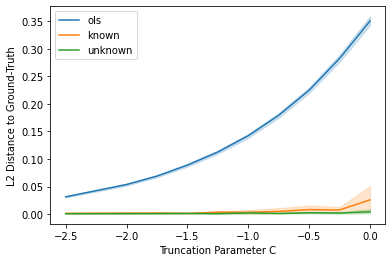

[Text(0.5, 0, 'Truncation Parameter C'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

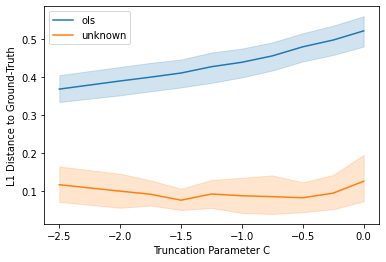

In [11]:
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols')
ax = sns.lineplot(data=logs, x='c', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='c', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance to Ground-Truth')

In [114]:
trunc_ols = LinearRegression().fit(x_trunc, y_trunc)
emp_noise_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
emp_noise_var

tensor([0.4925])

In [115]:
emp_noise_scale = ch.sqrt(emp_noise_var / 2)
emp_noise_scale

tensor([0.4962])

In [117]:
(emp_noise_var / 2).pow(.5)

tensor([0.4962])

In [120]:
new_noised = noised / ch.sqrt(emp_noise_var)
new_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

In [121]:
ols = LinearRegression().fit(x_trunc_norm, new_y_trunc)

In [122]:
(new_y_trunc - ols.predict(x_trunc_norm)).var(0)

tensor([1.])

In [112]:
another_ols = LinearRegression()
another_ols.fit(X, noised / noise_scale)

LinearRegression()

In [113]:
(noised - another_ols.predict(X)).var(0)

tensor([1.0035])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

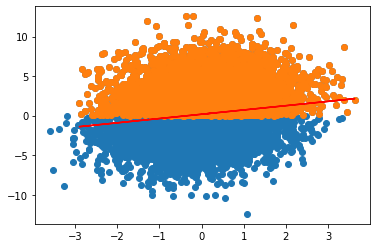

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])